# MLP Exercise - fantasy name generation

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
from src.layers import Linear, BatchNorm1d, LayerNorm1d, Tanh, Dropout
%matplotlib inline


In [2]:
# Get the datasets

import kagglehub

# Download latest version
path = kagglehub.dataset_download("isaacbenge/fantasy-for-markov-generator")

print("Path to dataset files:", path)

d:\dev\namegens\namegens\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Fern_PC II\.cache\kagglehub\datasets\isaacbenge\fantasy-for-markov-generator\versions\1


In [3]:
# clean data, normalize strings 
import glob
import pandas as pd 
allcsvs = []
for f in glob.glob(path+"/*.csv") + ["./names_clean.csv"]:
    df = pd.read_csv(f, header=None)
    series = (df[0].str.normalize('NFKD')
                   .str.encode('ascii', errors='ignore')
                   .str.decode('utf-8')
                   .str.lower()
                   .str.replace(r'[^\w\s]', '')
                   .str.replace('/', '')
                   .str.replace('(', '')
                   .str.replace(')', '')
                   .str.strip()
                   
                   )

    allcsvs.append(series)

# Adding names from names_clean.csv
words = pd.concat(allcsvs).to_list()


In [4]:
print(len(words))
words[:8]

28049


['mai', 'ba', 'binh', 'chi', 'cong', 'cuong', 'ha', 'hien']

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: "'", 3: '-', 4: '_', 5: 'a', 6: 'b', 7: 'c', 8: 'd', 9: 'e', 10: 'f', 11: 'g', 12: 'h', 13: 'i', 14: 'j', 15: 'k', 16: 'l', 17: 'm', 18: 'n', 19: 'o', 20: 'p', 21: 'q', 22: 'r', 23: 's', 24: 't', 25: 'u', 26: 'v', 27: 'w', 28: 'x', 29: 'y', 30: 'z', 0: '.'}
31


In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?
g = torch.Generator().manual_seed(2147483647) # for reproducibility

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([177783, 8]) torch.Size([177783])
torch.Size([21870, 8]) torch.Size([21870])
torch.Size([22348, 8]) torch.Size([22348])


In [ ]:
n_embd = 16 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Self-Attention layer class (single head)
class SelfAttention:
  def __init__(self, n_embd, head_size, block_size, dropout=0.0):
    self.n_embd = n_embd
    self.head_size = head_size
    self.block_size = block_size
    # Create Q, K, V projection matrices
    self.key = Linear(n_embd, head_size, bias=False)
    self.query = Linear(n_embd, head_size, bias=False)
    self.value = Linear(n_embd, head_size, bias=False)
    # Output projection
    self.proj = Linear(head_size, n_embd, bias=False)
    # Layer normalization after attention to stabilize gradients
    self.ln = LayerNorm1d(n_embd)
    # Causal mask: lower triangular matrix to prevent looking at future tokens
    self.register_buffer = lambda name, val: setattr(self, name, val)
    tril = torch.tril(torch.ones(block_size, block_size))
    self.dropout = nn.Dropout(dropout)

    self.register_buffer('mask', tril)
    
  def __call__(self, x):
    # x shape: (batch_size, block_size, n_embd)
    B, T, C = x.shape
    
    # Compute Q, K, V
    k = self.key(x)   # (B, T, head_size)
    q = self.query(x) # (B, T, head_size)
    v = self.value(x) # (B, T, head_size)
    
    # Compute attention scores: (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
    wei = q @ k.transpose(-2, -1) * self.head_size**-0.5  # scaled dot-product
    wei = wei.masked_fill(self.mask[:T, :T] == 0, float('-inf'))  # apply causal mask
    wei = F.softmax(wei, dim=-1)  # (B, T, T)
    
    # Apply attention to values
    out = wei @ v  # (B, T, head_size)
    
    # Output projection
    out = self.proj(out)  # (B, T, n_embd)
    
    # Layer normalization to stabilize gradients and prevent NaN
    out = self.ln(out)  # (B, T, n_embd)
    out = self.dropout(out)
    self.out = out
    return out
  
  def parameters(self):
    return (self.key.parameters() + self.query.parameters() + 
            self.value.parameters() + self.proj.parameters() + 
            self.ln.parameters())

# Multi-Head Self-Attention layer class
class MultiHeadAttention:
  def __init__(self, n_embd, num_heads, head_size, block_size, dropout=0.0):
    self.n_embd = n_embd
    self.num_heads = num_heads
    self.head_size = head_size
    self.block_size = block_size
    # Create Q, K, V projection matrices for all heads at once
    # Project to num_heads * head_size, then we'll split into heads
    self.key = Linear(n_embd, num_heads * head_size, bias=False)
    self.query = Linear(n_embd, num_heads * head_size, bias=False)
    self.value = Linear(n_embd, num_heads * head_size, bias=False)
    # Output projection (concatenated heads -> n_embd)
    self.proj = Linear(num_heads * head_size, n_embd, bias=False)
    # Layer normalization after attention to stabilize gradients
    self.ln = LayerNorm1d(n_embd)
    # Causal mask: lower triangular matrix to prevent looking at future tokens
    self.register_buffer = lambda name, val: setattr(self, name, val)
    tril = torch.tril(torch.ones(block_size, block_size))
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask', tril)
    
  def __call__(self, x):
    # x shape: (batch_size, block_size, n_embd)
    B, T, C = x.shape
    
    # Compute Q, K, V for all heads
    k = self.key(x)   # (B, T, num_heads * head_size)
    q = self.query(x) # (B, T, num_heads * head_size)
    v = self.value(x) # (B, T, num_heads * head_size)
    
    # Reshape to separate heads: (B, T, num_heads, head_size)
    # Then transpose to: (B, num_heads, T, head_size)
    k = k.view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, num_heads, T, head_size)
    q = q.view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, num_heads, T, head_size)
    v = v.view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, num_heads, T, head_size)
    
    # Compute attention scores for all heads in parallel
    # (B, num_heads, T, head_size) @ (B, num_heads, head_size, T) -> (B, num_heads, T, T)
    wei = q @ k.transpose(-2, -1) * self.head_size**-0.5  # scaled dot-product
    wei = wei.masked_fill(self.mask[:T, :T] == 0, float('-inf'))  # apply causal mask
    wei = F.softmax(wei, dim=-1)  # (B, num_heads, T, T)
    
    # Apply attention to values
    out = wei @ v  # (B, num_heads, T, head_size)
    
    # Concatenate heads: (B, num_heads, T, head_size) -> (B, T, num_heads * head_size)
    out = out.transpose(1, 2).contiguous().view(B, T, self.num_heads * self.head_size)
    
    # Output projection
    out = self.proj(out)  # (B, T, n_embd)
    
    # Layer normalization to stabilize gradients and prevent NaN
    out = self.ln(out)  # (B, T, n_embd)
    out = self.dropout(out)
    self.out = out
    return out
  
  def parameters(self):
    return (self.key.parameters() + self.query.parameters() + 
            self.value.parameters() + self.proj.parameters() + 
            self.ln.parameters())

C = torch.randn((vocab_size, n_embd),            generator=g)
# Create linear layer to transform embeddings before attention
# This will transform from n_embd to n_hidden dimension
linear_pre_attention = Linear(n_embd, n_hidden, bias=False)

# Multi-head attention configuration
num_heads = 4  # Number of attention heads
head_size = n_hidden // num_heads  # Each head processes head_size dimensions
# Ensure head_size * num_heads equals n_hidden
assert n_hidden % num_heads == 0, f"n_hidden ({n_hidden}) must be divisible by num_heads ({num_heads})"

# Choose attention type:
# Option 1: Single-head attention (original)
# attention = SelfAttention(n_hidden, n_hidden, block_size, 0.1)

# Option 2: Multi-head attention (recommended for better representation)
attention = MultiHeadAttention(n_hidden, num_heads, head_size, block_size, 0.1)

# Wrapper class to apply linear layer to 3D input (position-wise)
# Applies linear transformation to each position independently
class Linear3D:
  def __init__(self, linear_layer):
    self.linear = linear_layer
    
  def __call__(self, x):
    # x is 3D: (batch, seq_len, in_dim)
    B, T, C = x.shape
    # Reshape to 2D: (batch * seq_len, in_dim)
    x = x.view(B * T, C)
    # Apply linear layer
    x = self.linear(x)  # (batch * seq_len, out_dim)
    # Reshape back to 3D: (batch, seq_len, out_dim)
    x = x.view(B, T, -1)
    self.out = x
    return x
  
  def parameters(self):
    return self.linear.parameters()

# Wrapper class to integrate attention into layers list
# Handles 3D -> 2D conversion (attention outputs 3D, MLP expects 2D)
class AttentionFlatten:
  def __init__(self, attention_layer):
    self.attention = attention_layer
    
  def __call__(self, x):
    # x is 3D: (batch, seq_len, embd)
    x = self.attention(x)  # (batch, seq_len, embd)
    # Flatten to 2D: (batch, seq_len * embd)
    x = x.view(x.shape[0], -1)
    self.out = x 
    return x
  
  def parameters(self):
    return self.attention.parameters()

layers = [
  Linear3D(linear_pre_attention),  # Transform embeddings: (batch, seq_len, n_embd) -> (batch, seq_len, n_hidden)
  AttentionFlatten(attention),  # Attention + LayerNorm + Flatten: (batch, seq_len, n_hidden) -> (batch, seq_len * n_hidden)
  Linear(n_hidden * block_size, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), LayerNorm1d(vocab_size),
]
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

122062


In [24]:
# same optimization as last time
max_steps = 200000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors: (batch_size, block_size, n_embd)
  
  # Pass through all layers (attention + normalization are now in the layers list)
  x = emb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  layers[0].attention.out.retain_grad()  # Store attention output gradient
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x16 and 128x128)

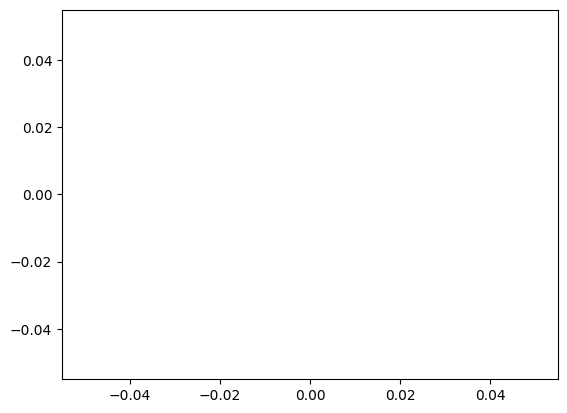

In [25]:

#plt.plot(lossi)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

layer 4 (      Tanh): mean -0.01, std 0.75, saturated: 24.91%
layer 8 (      Tanh): mean +0.00, std 0.75, saturated: 24.19%
layer 12 (      Tanh): mean +0.00, std 0.75, saturated: 21.12%
layer 16 (      Tanh): mean +0.00, std 0.74, saturated: 20.08%
layer 20 (      Tanh): mean -0.01, std 0.75, saturated: 20.15%
layer 24 (      Tanh): mean +0.01, std 0.76, saturated: 20.97%
layer 28 (      Tanh): mean -0.01, std 0.78, saturated: 26.10%


C:\Users\Fern_PC II\AppData\Local\Temp\ipykernel_14100\1397477801.py:7: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


Text(0.5, 1.0, 'activation distribution')

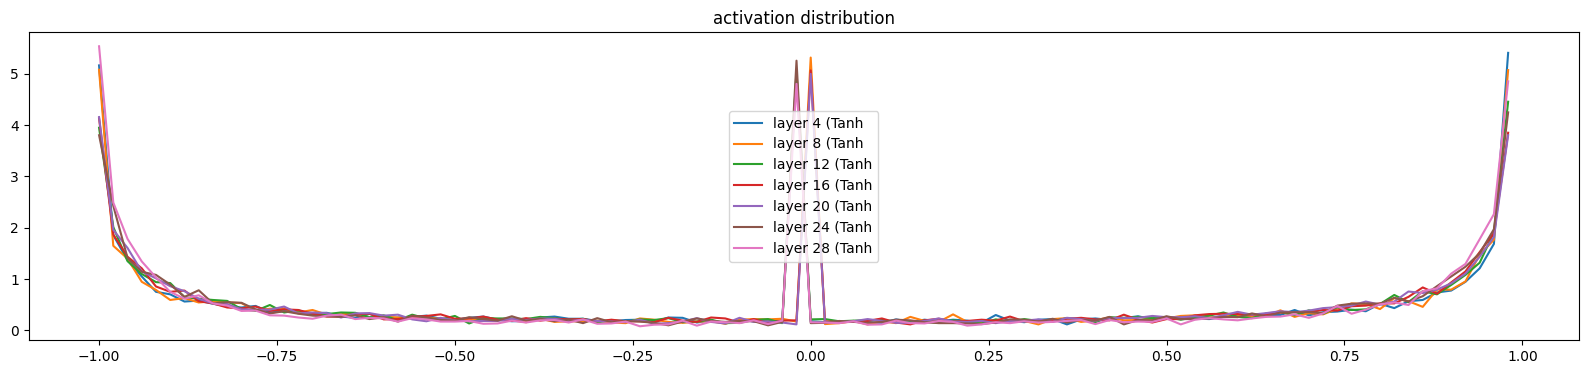

In [10]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 4 (      Tanh): mean -0.000004, std 1.341057e-03
layer 8 (      Tanh): mean -0.000008, std 1.109483e-03
layer 12 (      Tanh): mean -0.000002, std 9.462143e-04
layer 16 (      Tanh): mean -0.000002, std 8.544235e-04
layer 20 (      Tanh): mean -0.000006, std 8.021920e-04
layer 24 (      Tanh): mean +0.000003, std 8.339779e-04
layer 28 (      Tanh): mean +0.000009, std 8.698336e-04


Text(0.5, 1.0, 'gradient distribution')

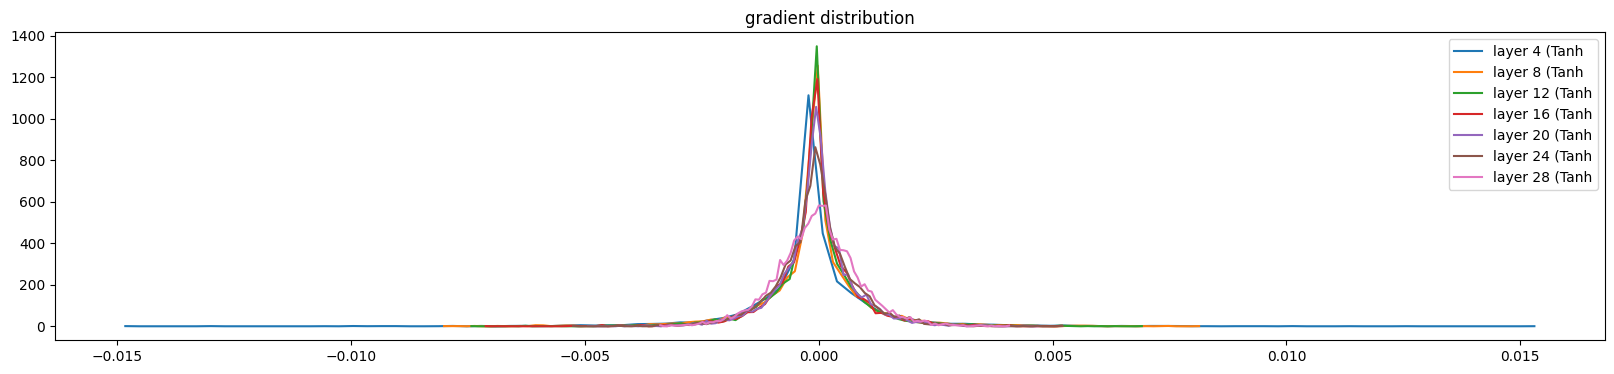

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (31, 16) | mean -0.000026 | std 8.989777e-03 | grad:data ratio 9.068837e-03
weight   (16, 16) | mean +0.000283 | std 8.238010e-03 | grad:data ratio 2.473586e-02
weight   (16, 16) | mean -0.000527 | std 7.904120e-03 | grad:data ratio 2.442727e-02
weight   (16, 16) | mean +0.000126 | std 1.519780e-02 | grad:data ratio 2.754131e-02
weight   (16, 16) | mean -0.000000 | std 1.725237e-02 | grad:data ratio 3.161341e-02
weight (128, 128) | mean -0.000000 | std 4.676815e-03 | grad:data ratio 2.997616e-02
weight (128, 128) | mean -0.000000 | std 3.624709e-03 | grad:data ratio 2.590752e-02
weight (128, 128) | mean +0.000000 | std 2.970480e-03 | grad:data ratio 2.266475e-02
weight (128, 128) | mean +0.000000 | std 2.574442e-03 | grad:data ratio 2.048614e-02
weight (128, 128) | mean -0.000000 | std 2.294714e-03 | grad:data ratio 1.859055e-02
weight (128, 128) | mean -0.000000 | std 2.170603e-03 | grad:data ratio 1.758025e-02
weight (128, 128) | mean -0.000000 | std 2.266295e-03 | grad:data

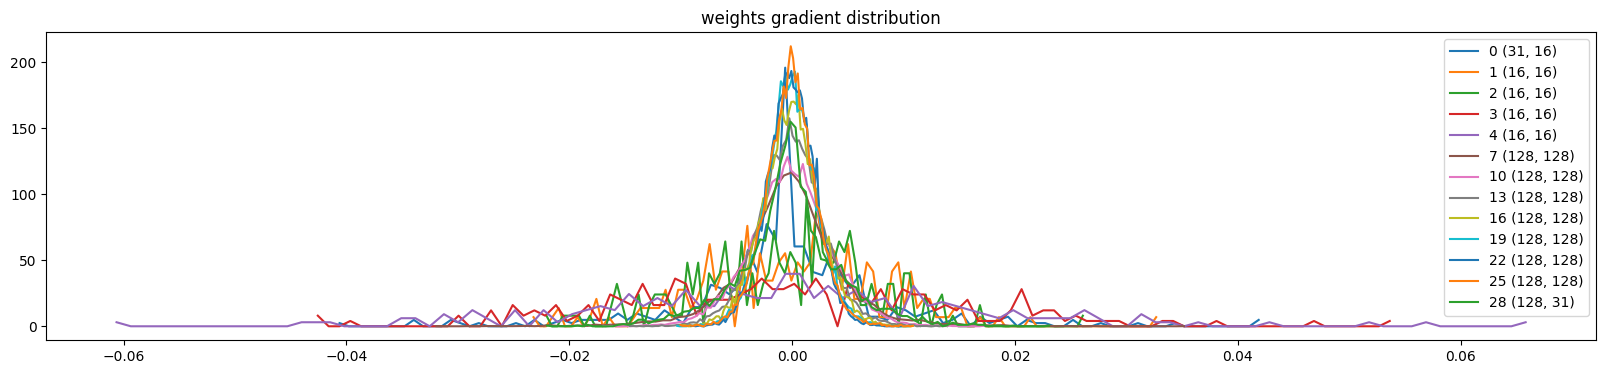

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

d:\dev\namegens\namegens\.env\Lib\site-packages\IPython\core\events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
d:\dev\namegens\namegens\.env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


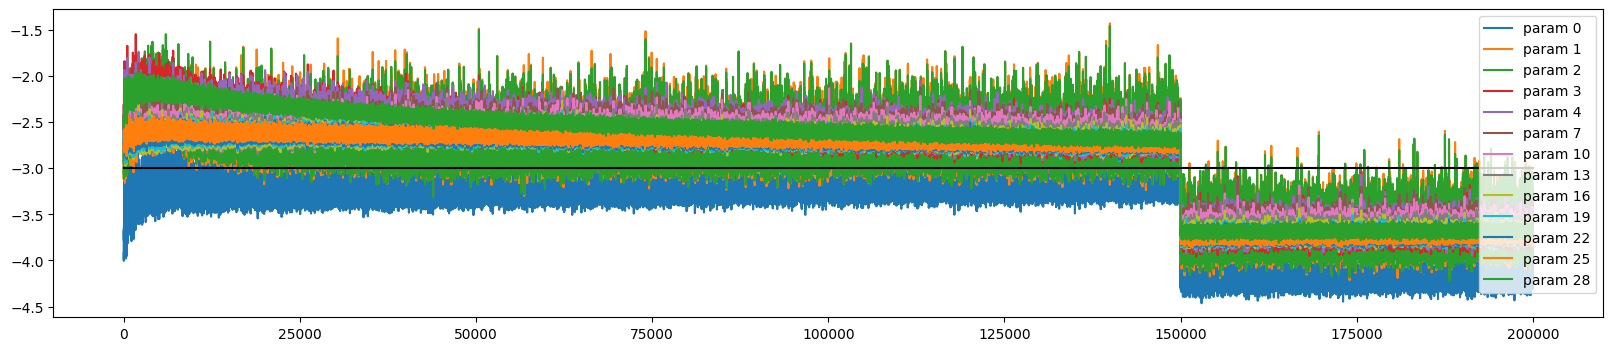

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  
  # Pass through all layers (attention + normalization are now in the layers list)
  x = emb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.186927556991577
val 2.2516708374023438


In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 22)

for _ in range(25):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = emb
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

nidro.
na.
terupethis.
arisa jing.
jong'doanefo.
alexsuy.
kermentinchino.
yinna.
edcle.
gyann.
dupsjachia.
kobpohiva.
cajista.
ze hiamerowirick.
olmend.
nuas.
joshan.
caron.
elosles.
ronce.
buhandra dazivac.
ssovosa.
nateria.
sackrah.
remo.


In [16]:
# sample from the model forcing more words
g = torch.Generator().manual_seed(2147483647 + 69)

for _ in range(25):
    has_space = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = emb
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if itos[ix] == ' ':
        has_space = True
      if ix == 0:
        if has_space==False:
            ix = stoi[' ']
            has_space = True
        else:
            break
      context = context[1:] + [ix]
      out.append(ix)

    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

jin'hun bo
hadasim stoope
trisy aramn
nikoli the teechrida
taameanto fo ov i
aethrey ghul-sharza
grederor straud phir h
avran cathing pashi
mest olthe
gandi hube
ketali cand ryind
sagimu grede
grati mil
aphon fiss
lackeris phover
nijantiama ghul-dlind
daks ina ghul-wyirds
lycina ghul-dhigokk
dacandlle giol win
diana ciavitebo
targam korbin
aditta gin shyomer
arisvfrotp i ceradacthe
steva dae
jong'hee pikh she dalee


In [22]:
# sample from the model forcing "the"
g = torch.Generator().manual_seed(2147483647 + 67)

for _ in range(25):
    has_the = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = emb
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if ix == 0:
        if has_the==False:
            context = context[5:] + [stoi[' '], stoi['t'], stoi['h'], stoi['e'], stoi[' ']]
            has_the = True
            out = out + [stoi[' '], stoi['t'], stoi['h'], stoi['e'], stoi[' ']]
        else:
            break
      else:
        context = context[1:] + [ix]
        out.append(ix)

    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

quenes the tayn
signis the it lincef
viveryina the ing
santimon the f
casia the bonst she og dranchparzaios
sabwot the tent
krett the nacitoun
lordo the bumrh
garni the migstafimsace
dedivio the mifp aas som
nudi the olvers
singmani the vabers
sung'jin the fithptyn
rufia the bharsien
matha the gals
desc the bu
judina the tsoung chul-kord
k the rartepon
khand the heod
alvirio the ibnja
breigas the bioon
carpasio the t
yong'owun the lii
irino the t
mil'ywa the 


In [18]:
print(out)
out[4:] + [stoi['t'], stoi['h'], stoi['e'], stoi[' ']]

[5, 22, 11, 19, 1, 24, 12, 9, 1, 24, 9, 16, 1, 18, 9, 7, 12, 16, 9]


[1, 24, 12, 9, 1, 24, 9, 16, 1, 18, 9, 7, 12, 16, 9, 24, 12, 9, 1]

In [19]:
stoi

{' ': 1,
 "'": 2,
 '-': 3,
 '_': 4,
 'a': 5,
 'b': 6,
 'c': 7,
 'd': 8,
 'e': 9,
 'f': 10,
 'g': 11,
 'h': 12,
 'i': 13,
 'j': 14,
 'k': 15,
 'l': 16,
 'm': 17,
 'n': 18,
 'o': 19,
 'p': 20,
 'q': 21,
 'r': 22,
 's': 23,
 't': 24,
 'u': 25,
 'v': 26,
 'w': 27,
 'x': 28,
 'y': 29,
 'z': 30,
 '.': 0}

In [20]:
C.shape

torch.Size([31, 16])

### from andrejs
train 2.0193495750427246
val 2.156538963317871
### bigger network
train 1.9244529008865356
val 2.1407828330993652
### adjusted sizes + more data
train 1.642111897468567
val 2.2296860218048096

good names tho